In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor


In [2]:
ticker = input("Enter Stock Symbol (e.g. AAPL, TSLA, INFY.NS): ")
data = yf.download(ticker, period="2y", interval="1d")
data.dropna(inplace=True)
data.tail()


C:\Users\AFNAN PASHA\AppData\Local\Temp\ipykernel_25196\3944132311.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period="2y", interval="1d")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GAIL.NS,GAIL.NS,GAIL.NS,GAIL.NS,GAIL.NS
Date,,,,,
2025-11-03,183.690002,184.440002,177.839996,182.440002,11050075
2025-11-04,181.619995,184.490005,180.750000,183.979996,11320462
2025-11-05,181.619995,181.619995,181.619995,181.619995,0
2025-11-06,178.979996,182.800003,178.649994,182.800003,8609714
2025-11-07,179.509995,179.889999,177.160004,178.300003,2085466


In [3]:
df = data.copy()
df['Prev_Close'] = df['Close'].shift(1)
df['Prev_Volume'] = df['Volume'].shift(1)
df['High_Low_Range'] = df['High'] - df['Low']
df.dropna(inplace=True)

X = df[['Prev_Close', 'Open', 'High', 'Low', 'Volume', 'High_Low_Range', 'Prev_Volume']]
y = df['Close']


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [5]:
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)

model.fit(X_train_scaled, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [6]:
y_pred = model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test.values - y_pred) / y_test.values)) * 100
accuracy = 100 - mape

print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


R²: 0.938
RMSE: 1.287
MAE: 1.013
MAPE: 3.29%
Accuracy: 96.71%


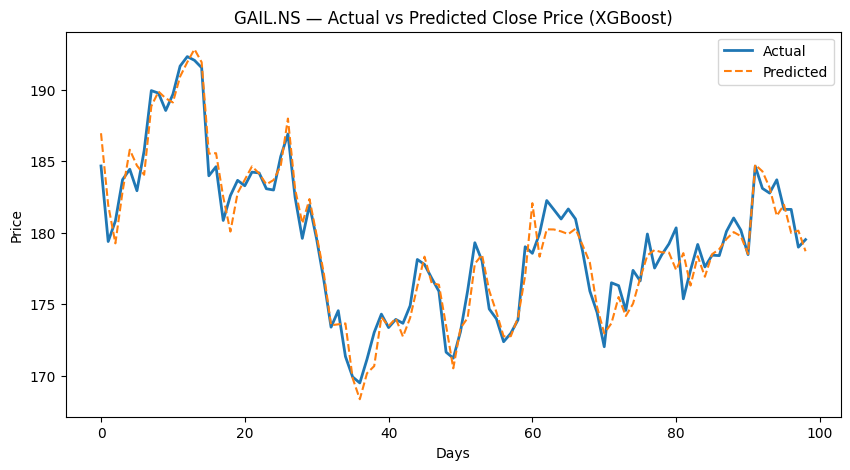

In [7]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linestyle='dashed')
plt.title(f"{ticker} — Actual vs Predicted Close Price (XGBoost)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()


In [8]:
latest = df.iloc[-1:]
latest_scaled = scaler.transform(latest[X.columns])

today_pred = model.predict(latest_scaled)[0]

# Simulate tomorrow’s input using today’s predicted close
tomorrow_input = latest.copy()
tomorrow_input['Prev_Close'] = today_pred
tomorrow_scaled = scaler.transform(tomorrow_input[X.columns])
tomorrow_pred = model.predict(tomorrow_scaled)[0]

print(f"\n📅 Predicted Closing Price:")
print(f"Today's Close:  {today_pred:.2f}")
print(f"Tomorrow's Close: {tomorrow_pred:.2f}")



📅 Predicted Closing Price:
Today's Close:  178.70
Tomorrow's Close: 178.71
